In [1]:
import math
from typing import Mapping

import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision.datasets import CelebA
from torchvision import transforms
import matplotlib.pyplot as plt

# SETUP

### Plotting

In [2]:
def show_with_attr(attr, has_attr, columns=5):
    train_idx = np.where(datasets[train_label].attr[:, attr] == has_attr)[0]
    valid_idx = np.where(datasets[valid_label].attr[:, attr] == has_attr)[0]
    attr_name = datasets[train_label].attr_names[attr]
    print(f"{attr_name}: {train_idx.shape[0]}, {valid_idx.shape[0]}")
    fig, ax = plt.subplots(1, columns, figsize=(20, 10))
    for i in range(columns):
        rnd = np.random.randint(0, train_idx.shape[0]-columns)
        rnd_idx = train_idx[rnd+i]
        ax[i].imshow(datasets[train_label][rnd_idx][0].permute(1, 2, 0))
        ax[i].set_title(f"{attr_name}: {rnd_idx}")
        ax[i].axis("off")

def show_identity_images(id, columns=5):
    valid_set = datasets[valid_label]
    idxs = np.where(valid_set.identity == id)[0]
    if len(idxs) == 0: 
        print("No images with that identity")
        return
    rows = math.ceil(len(idxs)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(10, 10))
    for i in range(columns*rows):
        if i < len(idxs):
            ax[i//columns, i%columns].imshow(valid_set[idxs[i]][0].permute(1, 2, 0))
            ax[i//columns, i%columns].set_title(f"Index: {idxs[i]}")
        ax[i//columns, i%columns].axis('off')
        
    plt.tight_layout()
    plt.show()

def plot_triplets(img_label_pairs):
    fig, ax = plt.subplots(len(img_label_pairs), 3, figsize=(10, 10))
    if len(img_label_pairs) == 1:
        ax = np.array([ax])
    titles = ["Anchor", "Positive", "Negative"]
    for i, (img, labels) in enumerate(img_label_pairs):
        for j in range(3):
            ax[i,j].imshow(img[j].permute(1, 2, 0))
            if labels:
                ax[i,j].set_title(f"{titles[j]}\nIdentity: {labels[j]}")
            ax[i,j].axis('off')
    
    # plt.subplots_adjust(hspace=1, wspace=-0.5)
    plt.tight_layout()
    plt.show()

def visualize_results(train_loss_history, val_loss_history, val_acc_history, batches_for_summary):
    assert len(train_loss_history) == len(val_loss_history) == len(val_acc_history) == len(batches_for_summary), "Unequal history lengths"
    x_axis = []
    cur_sum = 0
    for i in range(len(batches_for_summary)):
        cur_sum += batches_for_summary[i]
        x_axis.append(cur_sum)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(x_axis, train_loss_history, label="Train Loss")
    ax[0].plot(x_axis, val_loss_history, label="Val Loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Batches")
    ax[0].legend()
    ax[1].plot(x_axis, val_acc_history)
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Batches")
    plt.show()

def show_predictions(triplet_net, triplet_data_loader, num_correct=2, num_incorrect=2):
    correct_imgs = []
    incorrect_imgs = []
    cur_correct = 0
    cur_incorrect = 0
    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(triplet_data_loader):
            anchor, positive, negative = triplet_batch[0]
            anchors, positives, negatives = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
            anchors, positives, negatives = anchors.cpu(), positives.cpu(), negatives.cpu()
            for j in range(len(anchors)):
                anchor_pos_dist = np.linalg.norm(anchors[j] - positives[j])
                anchor_neg_dist = np.linalg.norm(anchors[j] - negatives[j])
                if anchor_pos_dist < anchor_neg_dist:
                    if cur_correct < num_correct:
                        correct_imgs.append(((anchor[j], positive[j], negative[j]), 
                                        [triplet_batch[1][0][j], triplet_batch[1][1][j], triplet_batch[1][2][j]]))
                        cur_correct += 1
                else:
                    if cur_incorrect < num_incorrect:
                        incorrect_imgs.append(((anchor[j], positive[j], negative[j]), 
                                        [triplet_batch[1][0][j], triplet_batch[1][1][j], triplet_batch[1][2][j]]))
                        cur_incorrect += 1
                if cur_correct == num_correct and cur_incorrect == num_incorrect:
                    break
            if cur_correct == num_correct and cur_incorrect == num_incorrect:
                break
        print("Correct predictions:")
        plot_triplets(correct_imgs)
        print("Incorrect predictions:")
        plot_triplets(incorrect_imgs)

def merge_trainstats_histories(old_history, add_to_history):
    for s in range(len(old_history)):
        old_history[s].extend(add_to_history[s])
    return old_history

def add_valstats_history(history, loss, acc):
    if len(history[0]) > 0:
        history[1][-1] = loss
        history[2][-1] = acc
    else:
        history[0], history[1], history[2], history[3] = [None], [loss], [acc], [0]

### Triplet Sampler and Dataset

In [3]:
# A triplet batch is (Labels, Images) x (Anchor, Positive, Negative) x Batch Size x Channels x Height x Width
# = 2 x 3 x 16 x 3 x 218 x 178

# Custom sampler class that generates batches with of triplets of images
class TripletSampler(data.sampler.Sampler):
    def __init__(self, dataset: CelebA, cleaned_identities: np.ndarray):
        self.dataset = dataset
        self.cleaned_identities = cleaned_identities
        self.identity_array = self.create_identity_array(cleaned_identities)

    def __getitem__(self, anchor_idx: int) -> tuple[int, int, int] | None:
        # Get a random anchor image and its identity
        anchor_identity = self.cleaned_identities[anchor_idx]
        if anchor_identity == 0: return None
        # Get all indexes with the same identity
        same_identity_idx = self.identity_array[anchor_identity]
        # remove the anchor image from the list
        same_identity_idx = same_identity_idx[same_identity_idx != anchor_idx]
        if len(same_identity_idx) == 0: return None
        # Get a random positive image
        positive_idx = same_identity_idx[np.random.randint(len(same_identity_idx))]
        # Get random index with different identity
        negative_idx = np.random.randint(len(self.dataset))
        while self.cleaned_identities[negative_idx] == anchor_identity:
            negative_idx = np.random.randint(len(self.dataset))

        return anchor_idx, positive_idx, negative_idx

    def __iter__(self):
        for i in range(len(self.dataset)):
            next_triple = self[i]
            if next_triple is None: continue
            yield next_triple

    def __len__(self):
        return len(self.dataset)

    @staticmethod
    def create_identity_array(identities: np.ndarray) -> np.ndarray:
        # Create array where identity is the index to an array of all indexes of images of that identity
        identity_array = np.empty(max(identities)+1, dtype=object)
        for i, id in enumerate(identities):
            if id == 0: continue
            if identity_array[id] is None:
                identity_array[id] = np.array([i])
            else:
                identity_array[id] = np.append(identity_array[id], i)
                
        return identity_array

class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: CelebA):
        self.dataset = dataset

    def __getitem__(self, triplet_idx: tuple[int, int, int]) -> tuple[tuple[torch.Tensor, torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
        anchor_idx, positive_idx, negative_idx = triplet_idx
        a_img, a_label = self.dataset[anchor_idx]
        p_img, p_label = self.dataset[positive_idx]
        n_img, n_label = self.dataset[negative_idx]
        assert a_label == p_label and a_label != n_label, "Error in triplet dataset"
        return (a_img, p_img, n_img), (a_label, p_label, n_label) 

    def __len__(self) -> int:
        return len(self.dataset)

In [4]:
data_dir = "data/"
bs = 16
target_type = 'identity'
train_label, valid_label, test_label = "train", "valid", "test"
dataset_labels = [train_label, valid_label, test_label]
dataset_transforms = {
    train_label: transforms.Compose(
    [transforms.ToTensor()]),
    valid_label: transforms.Compose(
    [transforms.ToTensor()]),
    test_label: transforms.Compose(
    [transforms.ToTensor()])
}
datasets: Mapping[str, CelebA] = {label : CelebA(root=data_dir, split=label, target_type=target_type, download=False, transform=dataset_transforms[label]) for label in dataset_labels}
dataset_sizes: Mapping[str, int] = {label: len(datasets[label]) for label in dataset_labels}
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### <a href="https://github.com/C3Imaging/Deep-Learning-Techniques/tree/clean-celebA">Data cleaning</a>

In [5]:
celeba_identity_clean = np.zeros(sum(dataset_sizes.values()), dtype=int)
with open("data/celeba/clean_CelebA_v1_img_list.txt", "r") as f:
    for line in f:
        identity, idx = line.split("/")
        celeba_identity_clean[int(idx[:-5])-1] = int(identity)

In [6]:
train_size = dataset_sizes[train_label]
different = (1 - sum(
    datasets[train_label].identity.numpy().squeeze() == celeba_identity_clean[:train_size]) / train_size) * 100
deleted = (sum(celeba_identity_clean == 0) / train_size) * 100
print(f"{round(deleted, 3)}% identities of deleted, {round(deleted-different, 3)}% identities of changed")

3.147% identities of deleted, 0.496% identities of changed


In [7]:
with open("data/celeba/deleted_CelebA_v1_img_list.txt", "r") as f:
    for line in f:
        identity, filename = line.split("/")
        idx = int(filename[:-5])-1
        if (idx < dataset_sizes[train_label] and datasets[train_label].identity[idx] != int(identity)) or celeba_identity_clean[idx] != 0:
            print("Error")
            break
    else: print("Verified changed and deleted identities")

Verified changed and deleted identities


### Attribute filtering

In [8]:
def filter_attr(attr_id: int):
    all_attr = np.concatenate((datasets[train_label].attr, datasets[valid_label].attr, datasets[test_label].attr))
    has_attr = all_attr[:, attr_id] == 1
    val_start = dataset_sizes[train_label]
    test_start = val_start+dataset_sizes[valid_label]
    
    # count how many are set to 0 from each set, that wasn't already 0 in celeba_identity_clean
    train_removed = sum(has_attr[:val_start] & (celeba_identity_clean[:val_start] != 0))
    valid_removed = sum(has_attr[val_start:test_start] & (celeba_identity_clean[val_start:test_start] != 0))
    test_removed = sum(has_attr[test_start:] & (celeba_identity_clean[test_start:] != 0))
    celeba_identity_clean[has_attr] = 0

    print(f"Removing all with attribute '{datasets[train_label].attr_names[attr_id]}'")
    print(f" Removed from train: {train_removed} ({sum(has_attr[:val_start])})")
    print(f" Removed from valid: {valid_removed} ({sum(has_attr[val_start:test_start])})")
    print(f" Removed from test: {test_removed} ({sum(has_attr[test_start:])})")
    print(f" Total removed: {train_removed + valid_removed + test_removed} ({sum(has_attr)})")
    print()

filter_attr(10)
filter_attr(35)

Removing all with attribute 'Blurry'
 Removed from train: 7934 (8362)
 Removed from valid: 904 (940)
 Removed from test: 981 (1010)
 Total removed: 9819 (10312)

Removing all with attribute 'Wearing_Hat'
 Removed from train: 7358 (8039)
 Removed from valid: 859 (940)
 Removed from test: 770 (839)
 Total removed: 8987 (9818)


### Post-cleaning summary

In [9]:
train_size = dataset_sizes[train_label]
valid_size = dataset_sizes[valid_label]
test_size = dataset_sizes[test_label]

train_left = sum(celeba_identity_clean[:train_size] != 0)
valid_left = sum(celeba_identity_clean[train_size:train_size+valid_size] != 0)
test_left = sum(celeba_identity_clean[train_size+valid_size:] != 0)
print(f"Train samples left: {train_left}, from {train_size} ({train_left - train_size})")
print(f"Valid samples left: {valid_left}, from {valid_size} ({valid_left - valid_size})")
print(f"Test samples left: {test_left}, from {test_size} ({test_left - test_size})")

Train samples left: 143164, from 162770 (-19606)
Valid samples left: 17653, from 19867 (-2214)
Test samples left: 17854, from 19962 (-2108)


In [10]:
cleaned_identities_splits = {"train": celeba_identity_clean[:len(datasets[train_label])],
                             "valid": celeba_identity_clean[len(datasets[train_label]):len(datasets[train_label])+len(datasets[valid_label])],
                             "test": celeba_identity_clean[len(datasets[train_label])+len(datasets[valid_label]):]}
dataloaders: Mapping[str, data.DataLoader] = {label:  data.DataLoader(TripletDataset(datasets[label]), batch_size=bs, shuffle=False, num_workers=0, sampler=TripletSampler(datasets[label], cleaned_identities_splits[label])) for label in dataset_labels}

# Model & Fit

In [11]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity() # Override last layer of resnet to replace with our own fc layers
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )

        # Initialize the fc layers with xavier
        for layer in self.fc:
            if type(layer) == nn.Linear:
                nn.init.xavier_uniform_(layer.weight)


    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        anchor = self.resnet(anchor)
        anchor = self.fc(anchor)
        positive = self.resnet(positive)
        positive = self.fc(positive)
        negative = self.resnet(negative)
        negative = self.fc(negative)
        return anchor, positive, negative


def train_triplet_net(triplet_net: TripletNet,
                      criterion,
                      optimizer,
                      lr_scheduler,
                      epochs,
                      num_batches=None,
                      num_val_batches=None,
                      freeze=False,
                      summary_time=250,
                      verbose=True):
    
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    if num_batches is None: num_batches = len(dataloaders[train_label])
    if summary_time is None: summary_time = num_batches
    if num_batches < summary_time: print(f"Warning: num_batches ({num_batches}) < batches_summary ({summary_time})")

    print_stats = lambda: print(f"Epoch: {epoch + 1}, Batch: {batch_i + 1}",
                                f"Train Loss: {round(running_loss / summary_time, 3)}",
                                f"Val Loss: {round(val_loss, 3)}",
                                f"Val Accuracy: {round(val_acc, 3)}",
                                end='\n' if verbose else '\r')
                                # f"Train Accuracy: {correct_preds / (batches_summary * triplet_data_loader.batch_size)}"
    
    for param in triplet_net.resnet.parameters():
        param.requires_grad = not freeze
    triplet_net.fc.requires_grad = True

    train_step = make_train_step(triplet_net, criterion, optimizer)

    try:
        for epoch in range(epochs):
            running_loss = 0.0
            for batch_i,triplet_batch in enumerate(dataloaders[train_label]):
                running_loss += train_step(triplet_batch)

                if batch_i % summary_time == summary_time - 1:
                    print("Validating...      ", end='\r')
                    val_loss, val_acc = val_triplet_net(triplet_net, criterion, batches=num_val_batches)
                    print("", end='\r')
                    val_loss_history.append(val_loss)
                    val_acc_history.append(val_acc)
                    train_loss_history.append(running_loss / summary_time)
                    print_stats()
                    running_loss = 0.0
                    
                    lr_scheduler.step() 
                else:
                    print(f"Train Loss: {round(loss.item(), 3)}", end='\r')
                

                if batch_i == num_batches - 1: # Skip to next epoch
                    # print("Validating...", end='\r')
                    # val_loss, val_acc = val_triplet_net(triplet_net, criterion, batches=num_val_batches)
                    # print("", end='\r')
                    # print_stats()
                    # print()
                    break

    except KeyboardInterrupt:
        print("\nKeyboard Interrupt. Final stats:\n")
        # val_loss, val_acc = val_triplet_net(triplet_net, criterion, verbose=0)
        print_stats()
        
    print("Finished Training\n")
    return train_loss_history, val_loss_history, val_acc_history, [summary_time] * len(train_loss_history)

# Builds function that performs a step in the training loop for the provided model, criterion and optimizer. 
def make_train_step(model: nn.Module, triplet_loss,  optimizer): 
    def train_step(triplet_batch):
        model.train()
        anchors, positives, negatives = triplet_batch[0]
        anchors, positives, negatives = triplet_net(anchors.cuda(), positives.cuda(), negatives.cuda())
        loss = triplet_loss(anchors, positives, negatives)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

def val_triplet_net(triplet_net: TripletNet, criterion, verbose=0, batches=None) -> tuple[float, float]:
    # bs, total_samples = 64, 19862
    running_loss = 0.0
    correct_predictions = 0
    samples_done = 0

    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(dataloaders[valid_label]):
            if i == batches: break
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
            running_loss += criterion(anchor, positive, negative).item() * len(anchor)
            anchor, positive, negative = anchor.cpu(), positive.cpu(), negative.cpu()
            samples_done += len(anchor)
            for j in range(len(anchor)):
                anchor_pos_dist = np.linalg.norm(anchor[j] - positive[j])
                anchor_neg_dist = np.linalg.norm(anchor[j] - negative[j])
                closest = np.argmin([anchor_neg_dist, anchor_pos_dist])
                correct_predictions += closest
                if verbose == 2:
                    print("Anchor Positive Distance:", anchor_pos_dist)
                    print("Anchor Negative Distance:", anchor_neg_dist)
                    print("Closest:", ["Negative", "Positive"][closest])
                    
        # samples_done = min((i+1)*bs, total_samples)
        accuracy = correct_predictions / samples_done
        val_loss = running_loss / samples_done
        if verbose >= 1:
            print(f"Val Loss: {val_loss:.3f}, Val Accuracy: {accuracy:.3f} ({correct_predictions}/{samples_done})")
        if verbose == 2: print()

        triplet_net.train()
        return val_loss, accuracy

# Fit model, show results and predict

In [12]:
triplet_net = TripletNet()
triplet_net.cuda()

batches_summary = 10
history = [[], [], [], []]

criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adam(triplet_net.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=1, total_iters=100) # Constant for now
#lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=3000)

In [13]:
print("Initial validation loss and accuracy:")
loss, acc = val_triplet_net(triplet_net, criterion, batches=5, verbose=1)
add_valstats_history(history, loss, acc)

Initial validation loss and accuracy:
Val Loss: 0.647, Val Accuracy: 0.725 (58/80)


In [14]:
new_history = train_triplet_net(triplet_net,
                                criterion,
                                optimizer,
                                lr_scheduler,
                                freeze=True,
                                epochs=1,
                                num_batches=10,
                                num_val_batches=50,
                                summary_time=batches_summary)

override = False # True
history = new_history if override else merge_trainstats_histories(history, new_history)

Epoch: 1, Batch: 10 Train Loss: 0.721 Val Loss: 0.662 Val Accuracy: 0.761
Finished Training


In [15]:
print("Final validation loss and accuracy:")
loss, acc = val_triplet_net(triplet_net, criterion, batches=2, verbose=1)
add_valstats_history(history, loss, acc)

Final validation loss and accuracy:
Val Loss: 0.662, Val Accuracy: 0.688 (22/32)


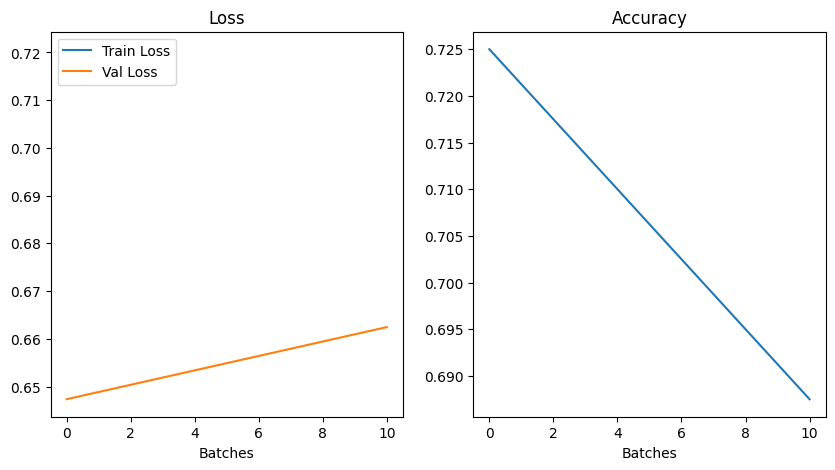

In [16]:
visualize_results(*history)

Correct predictions:


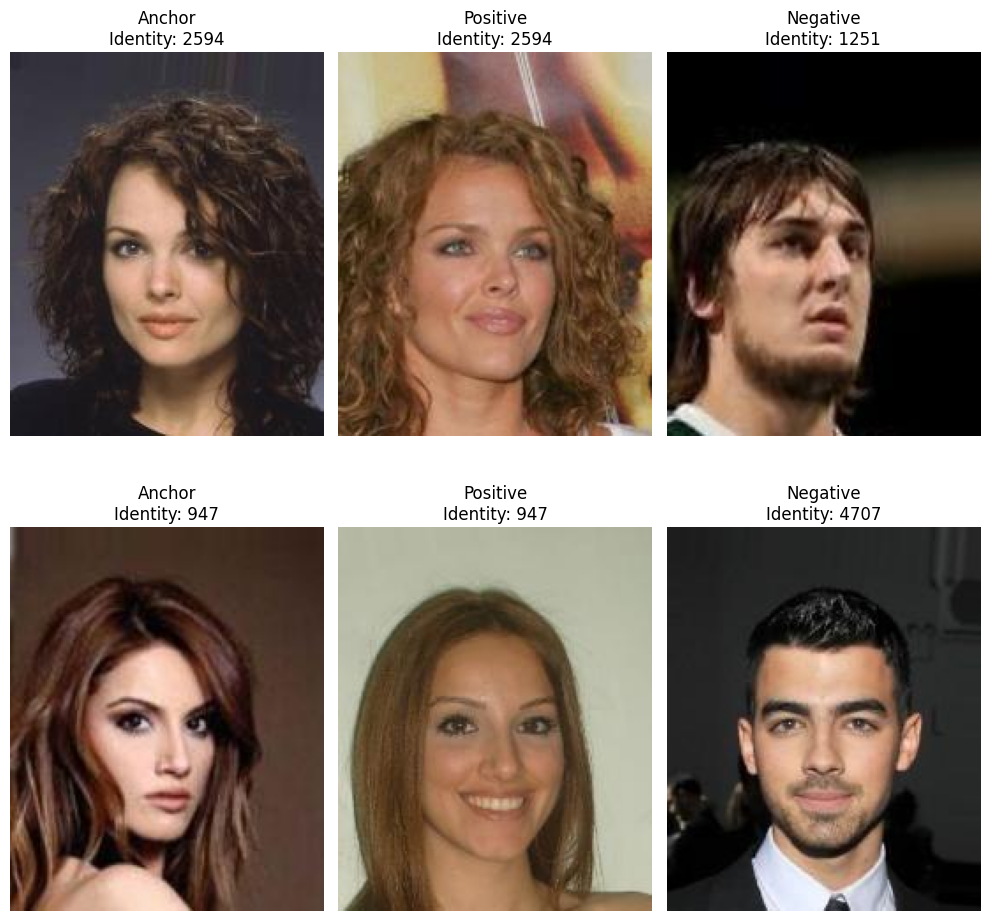

Incorrect predictions:


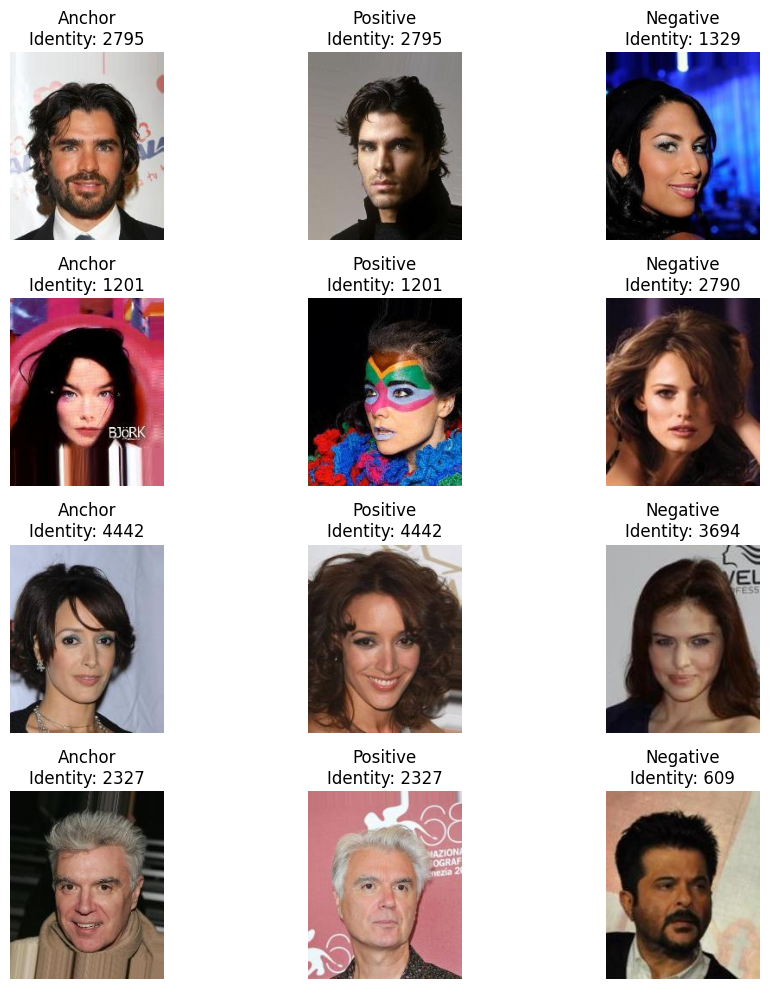

In [17]:
show_predictions(triplet_net, dataloaders[valid_label], num_correct=2, num_incorrect=4)

### Save and load model and result history

In [18]:
checkpoint = {
    "model": triplet_net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "lr_scheduler": lr_scheduler.state_dict(),
    "history": history,
}
torch.save(checkpoint, "models/triplet_net3.pt")

In [19]:
checkpoint = torch.load("models/triplet_net3.pt")
triplet_net.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
history = checkpoint["history"]

### Grad-CAM Test

In [20]:
# print resnet
# print(triplet_net.resnet)

In [21]:
triplet_net.resnet.layer4[1].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [22]:
triplet_net.resnet.layer4[1].conv2.weight.shape

torch.Size([512, 512, 3, 3])

In [23]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

# We register our hooks to the conv2 layer
triplet_net.resnet.layer4[1].conv2.register_full_backward_hook(backward_hook)
triplet_net.resnet.layer4[1].conv2.register_full_forward_hook(forward_hook)

# We run the model on a batch of images
triplet_net.eval()
with torch.no_grad():
  anchor, positive, negative = next(iter(dataloaders[train_label]))[0]
  anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
  anchor, positive, negative = triplet_net(anchor, positive, negative)


AttributeError: 'Conv2d' object has no attribute 'register_full_forward_hook'

In [ ]:

# plot activation of last conv layer of resnet
img = datasets[train_label][0][0].unsqueeze(0)
layer = triplet_net.resnet.layer4[1].conv2
triplet_net.eval()
with torch.no_grad():
    _, _, activations = triplet_net(img.cuda(), img.cuda(), img.cuda())
    activations = activations.cpu().numpy()
    activations = np.mean(activations, axis=1).squeeze()
    plt.imshow(activations)
    plt.show()



### Could be useful

In [ ]:
# Show the embeddings of the all images of the first 10 people

# get all images of the first 10 people
train_set = datasets[train_label]
first_10_idx = torch.where(train_set.identity <= 10)[0]

# get all embeddings of triplet_net of the first 10 people
first_10_embeddings = []
# first_10_imgs = []
for batch_i in first_10_idx:
    img, label = train_set[batch_i]
    # first_10_imgs.append(img)
    img = img.cuda()
    img = img.unsqueeze(0)
    embedding = triplet_net.resnet(img)
    first_10_embeddings.append(embedding)

first_10_labels = train_set.identity[first_10_idx].numpy()

# find first image of each of the first 10 people
first_10_imgs = []
for batch_i in range(1,11):
    idx = torch.where(train_set.identity == batch_i)[0][0]
    img, label = train_set[idx]
    first_10_imgs.append(img)

# show one image of each of the first 10 people
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for batch_i, img in enumerate(first_10_imgs):
    ax[batch_i].imshow(img.permute(1, 2, 0))
    ax[batch_i].set_title(f"Identity: {batch_i + 1}")
    ax[batch_i].axis('off')
plt.show()

# plot the embeddings of the first 10 people
first_10_embeddings = torch.stack(first_10_embeddings)
first_10_embeddings = first_10_embeddings.squeeze(1)
first_10_embeddings = first_10_embeddings.cpu().detach().numpy()
plt.scatter(first_10_embeddings[:, 0], first_10_embeddings[:, 1], c=first_10_labels)
plt.show()

# print identity with lowest and largest embedding value
max_idx = np.argmax(first_10_embeddings[:, 0])
print("Identity with largest embedding value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings[:, 0])
print("Identity with lowest embedding value:")
print(first_10_labels[min_idx])

# Show the embeddings of the first 10 people with TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
first_10_embeddings_tsne = tsne.fit_transform(first_10_embeddings)
# show legend with 10 identities
plt.legend([f"Identity: {i + 1}" for i in range(10)])
plt.scatter(first_10_embeddings_tsne[:, 0], first_10_embeddings_tsne[:, 1], c=first_10_labels, cmap='tab10')
plt.show()

# print identity with lowest and largest TNES value
max_idx = np.argmax(first_10_embeddings_tsne[:, 0])
print("Identity with largest TNES value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings_tsne[:, 0])
print("Identity with lowest TNES value:")
print(first_10_labels[min_idx])
